In [21]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, avg, date_format, min
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import Summarizer
from pyspark import pandas as ps
import matplotlib.pyplot as plt

In [3]:
# conf = SparkConf()

# conf.set("spark.master", "local[*]")
# .config(config=conf)

spark = SparkSession.builder \
    .master('spark://spark-master:7077') \
    .appName('W4M2') \
    .config('spark.executor.memory', '12gb') \
    .config("spark.cores.max", "20") \
    .getOrCreate()

# 1. Data Loading
- Load the TLC Trip Record Data into a Spark DataFrame

In [4]:
df = spark.read.parquet('../data/fhvhv_tripdata_2024-01.parquet')

In [6]:
df.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2024-01-01 00:21:47 
 on_scene_datetime    | 2024-01-01 00:25:06 
 pickup_datetime      | 2024-01-01 00:28:08 
 dropoff_datetime     | 2024-01-01 01:05:39 
 PULocationID         | 161                 
 DOLocationID         | 158                 
 trip_miles           | 2.83                
 trip_time            | 2251                
 base_passenger_fare  | 45.61               
 tolls                | 0.0                 
 bcf                  | 1.25                
 sales_tax            | 4.05                
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 0.0                 
 driver_pay           | 40.18               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

# 2. Data Cleaning
## 2.1. Handle missing values by either removing or imputing them.

### Before data cleaning

In [7]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-----------------------
 hvfhs_license_num    | 0       
 dispatching_base_num | 0       
 originating_base_num | 5218737 
 request_datetime     | 0       
 on_scene_datetime    | 5218737 
 pickup_datetime      | 0       
 dropoff_datetime     | 0       
 PULocationID         | 0       
 DOLocationID         | 0       
 trip_miles           | 0       
 trip_time            | 0       
 base_passenger_fare  | 0       
 tolls                | 0       
 bcf                  | 0       
 sales_tax            | 0       
 congestion_surcharge | 0       
 airport_fee          | 0       
 tips                 | 0       
 driver_pay           | 0       
 shared_request_flag  | 0       
 shared_match_flag    | 0       
 access_a_ride_flag   | 0       
 wav_request_flag     | 0       
 wav_match_flag       | 0       



In [8]:
df = df.na.drop('any')

### After data cleaning

In [9]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-------------------
 hvfhs_license_num    | 0   
 dispatching_base_num | 0   
 originating_base_num | 0   
 request_datetime     | 0   
 on_scene_datetime    | 0   
 pickup_datetime      | 0   
 dropoff_datetime     | 0   
 PULocationID         | 0   
 DOLocationID         | 0   
 trip_miles           | 0   
 trip_time            | 0   
 base_passenger_fare  | 0   
 tolls                | 0   
 bcf                  | 0   
 sales_tax            | 0   
 congestion_surcharge | 0   
 airport_fee          | 0   
 tips                 | 0   
 driver_pay           | 0   
 shared_request_flag  | 0   
 shared_match_flag    | 0   
 access_a_ride_flag   | 0   
 wav_request_flag     | 0   
 wav_match_flag       | 0   



## 2.2 Convert all relevant time fields to a standard timestamp format.


In [10]:
df = spark.read.parquet('../data/fhvhv_tripdata_2024-01.parquet')

df = df.withColumn("request_datetime", date_format(df.request_datetime,'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("on_scene_datetime", date_format(df.on_scene_datetime,'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("pickup_datetime", date_format(df.pickup_datetime,'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("dropoff_datetime", date_format(df.dropoff_datetime,'yyyy-MM-dd HH:mm:ss'))

df.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2024-01-01 00:21:47 
 on_scene_datetime    | 2024-01-01 00:25:06 
 pickup_datetime      | 2024-01-01 00:28:08 
 dropoff_datetime     | 2024-01-01 01:05:39 
 PULocationID         | 161                 
 DOLocationID         | 158                 
 trip_miles           | 2.83                
 trip_time            | 2251                
 base_passenger_fare  | 45.61               
 tolls                | 0.0                 
 bcf                  | 1.25                
 sales_tax            | 4.05                
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 0.0                 
 driver_pay           | 40.18               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

## 2.3. Filter out records with non-sensical values (e.g., negative trip duration or distance).
- df.describe method를 이용하여 min, max 값 확인 결과, base_passenger_fare와 driver_pay에 음수 값이 있다는 것 확인
- 비용이 음수인 경우는 일반적인 상황이 아니라고 가정하고, 해당 주행 정보(row) 전체를 drop 함.

In [11]:
# df.select(min(df.request_datetime), min(df.on_scene_datetime), min(df.pickup_datetime), min(df.dropoff_datetime),\
#          min(df.request_datetime), min(df.request_datetime), min(df.request_datetime), min(df.request_datetime),\
#          ).show()

In [12]:
df.describe(df.columns).show(vertical=True)

-RECORD 0-----------------------------------
 summary              | count               
 hvfhs_license_num    | 19663930            
 dispatching_base_num | 19663930            
 originating_base_num | 14445193            
 request_datetime     | 19663930            
 on_scene_datetime    | 14445193            
 pickup_datetime      | 19663930            
 dropoff_datetime     | 19663930            
 PULocationID         | 19663930            
 DOLocationID         | 19663930            
 trip_miles           | 19663930            
 trip_time            | 19663930            
 base_passenger_fare  | 19663930            
 tolls                | 19663930            
 bcf                  | 19663930            
 sales_tax            | 19663930            
 congestion_surcharge | 19663930            
 airport_fee          | 19663930            
 tips                 | 19663930            
 driver_pay           | 19663930            
 shared_request_flag  | 19663930            
 shared_ma

In [13]:
df = df.filter(df.driver_pay > 0)
df = df.filter(df.base_passenger_fare > 0)

In [14]:
df.describe(df.columns).show(vertical=True)

-RECORD 0-----------------------------------
 summary              | count               
 hvfhs_license_num    | 19651963            
 dispatching_base_num | 19651963            
 originating_base_num | 14440292            
 request_datetime     | 19651963            
 on_scene_datetime    | 14440292            
 pickup_datetime      | 19651963            
 dropoff_datetime     | 19651963            
 PULocationID         | 19651963            
 DOLocationID         | 19651963            
 trip_miles           | 19651963            
 trip_time            | 19651963            
 base_passenger_fare  | 19651963            
 tolls                | 19651963            
 bcf                  | 19651963            
 sales_tax            | 19651963            
 congestion_surcharge | 19651963            
 airport_fee          | 19651963            
 tips                 | 19651963            
 driver_pay           | 19651963            
 shared_request_flag  | 19651963            
 shared_ma

# Calculation of Metrics
- Compute the average duration of trips.

In [15]:
df.select(avg(df.trip_time).alias("average trip time (s)")).show()

+---------------------+
|average trip time (s)|
+---------------------+
|   1110.5638864677285|
+---------------------+



- Compute the average distance of trips.

In [16]:
df.select(avg(df.trip_miles).alias("average trip distance (miles)")).show()

+-----------------------------+
|average trip distance (miles)|
+-----------------------------+
|            4.839156592092115|
+-----------------------------+



# Peak Hours Identification
Identify the peak hours for taxi usage.

1. Add column for 'hour' info.

In [17]:
df = df.withColumn("hour", date_format(df.request_datetime,'H'))
df = df.withColumn("hour", df['hour'].cast(IntegerType()))

2. Casting hour column(str to int)

In [18]:
df_hour = df.groupBy("hour").count()
df_hour.orderBy("hour").show(df.count())

+----+-------+
|hour|  count|
+----+-------+
|   0| 684232|
|   1| 481513|
|   2| 358224|
|   3| 292748|
|   4| 290602|
|   5| 354854|
|   6| 571976|
|   7| 896195|
|   8|1017849|
|   9| 900531|
|  10| 817060|
|  11| 809946|
|  12| 834429|
|  13| 872312|
|  14| 966632|
|  15| 981533|
|  16|1028394|
|  17|1177498|
|  18|1212700|
|  19|1146124|
|  20|1051746|
|  21|1024729|
|  22|1001831|
|  23| 878305|
+----+-------+



In [22]:
ps_df_hour = ps.DataFrame(df_hour)
np_hour_cnt = ps_df_hour.to_numpy()
np_hour_cnt

/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


array([[     12,  834429],
       [     22, 1001831],
       [      1,  481513],
       [     13,  872312],
       [      6,  571976],
       [     16, 1028394],
       [      3,  292748],
       [     20, 1051746],
       [      5,  354854],
       [     19, 1146124],
       [     15,  981533],
       [      9,  900531],
       [     17, 1177498],
       [      4,  290602],
       [      8, 1017849],
       [     23,  878305],
       [      7,  896195],
       [     10,  817060],
       [     21, 1024729],
       [     11,  809946],
       [     14,  966632],
       [      2,  358224],
       [      0,  684232],
       [     18, 1212700]])

['0 K', '100 K', '200 K', '300 K', '400 K', '500 K', '600 K', '700 K', '800 K', '900 K', '1000 K', '1100 K', '1200 K']


Text(0.5, 1.0, 'Peak Hours Identification')

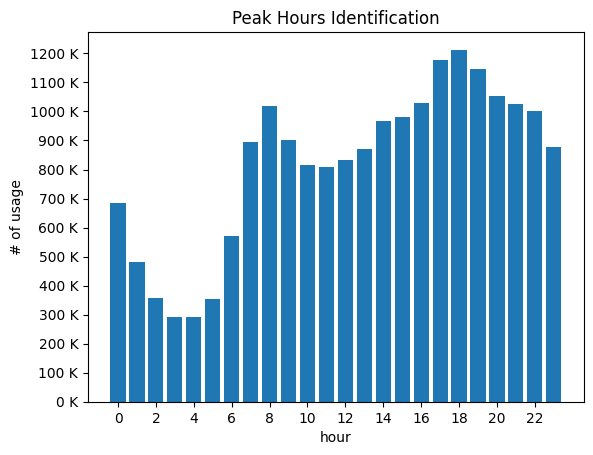

In [32]:
max_cnt = np_hour_cnt[:,1].max()
interval = 100000
plt.bar(np_hour_cnt[:,0], np_hour_cnt[:,1])
plt.xlabel("hour")
plt.ylabel("# of usage")
plt.xticks([x for x in range(0, 24, 2)])

y_ticks_str = [str(round(x/1000))+' K' for x in range(0, max_cnt, interval)]

plt.yticks([y for y in range(0, max_cnt, interval)], y_ticks_str)
print(y_ticks_str)
plt.title("Peak Hours Identification")